# Shifts and Lags

In [203]:
# libraries
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
library(brms)
library(loo)
library(haven)
library(ggridges)
library(sdazar)
library(data.table)
library(MASS)
library(stringr)

# library(bayesplot)
library(forcats)
library(ggplot2)
library(patchwork)
options(repr.plot.width = 5, repr.plot.height = 3)
source('Rutils/functions.R')

In [205]:
# load data
df = data.table(read_stata('../data/Ex_LA1850-2013_SES_ABBREVIATED_april-3-2018.dta'))

In [206]:
country_labels = c("Argentina", "Bolivia", "Brazil", "Chile", "Colombia", 
                   "Costa_Rica", "Cuba", "Dominican_Republic", "Ecuador", 
                   "El_Salvador", "Guatemala", "Honduras", "Mexico", "Nicaragua", 
                   "Panama", "Paraguay", "Peru", "Uruguay", "Venezuela")

In [207]:
df[, ctry := factor(ctry, labels=country_labels)]

In [208]:
# intrapolation?
# x <- 1:10
# y <- rnorm(10)

# plot(x, y, main = "approx(.) and approxfun(.)")
# # points(approx(x, y), col = 2, pch = "*")
# points(approx(y, method = "linear"), col = 4, pch = "*")

# Male

In [209]:
male = df[tseries2==1 & sex==1 & age==0]

male = male[complete.cases(male[, .(Ex, gdp_pc)])]

male = male[, .(ctry, year, gdp_pc, Ex)]
setnames(male, c('gdp_pc', 'Ex'), c('gdp', 'le'))

In [210]:
male[, le_log := scale(log(le), scale=FALSE)]
male[, gdp_log := scale(log(gdp), scale=FALSE)]
male[, year_log := scale(log(year), scale=FALSE)]

In [211]:
# year recode based on the criteria proposed by Alberto
male[year<1950, gyear:=1]
male[year>=1950 & year<1970, gyear:=2]
male[year>=1970 & year<1990, gyear:=3]
male[year>=1990, gyear :=4]
male[, gyear := factor(gyear, levels=1:4, labels=c('1950', '1950-1969', '1970-1989', '1990'))]

In [212]:
# transform variable: weibull
male[, y := le/max(le+1.05), by = ctry] # adjustment is by country!
male[, wy := log(-log(1-y))]

In [334]:
max_le_male = male[, .(max_le = max(le+1.05)), by = ctry]

In [214]:
# function
get_orig_values_weibull = function(x, max_value) { 
    return ( (1 - exp(-exp(x))) * max_value )
}

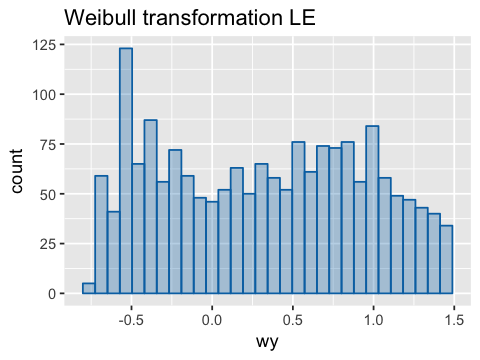

In [215]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(male, aes(wy)) +
    geom_histogram(bins=30, color='#0072B2', fill='#0072B2', alpha=0.3) +
    labs(title='Weibull transformation LE')

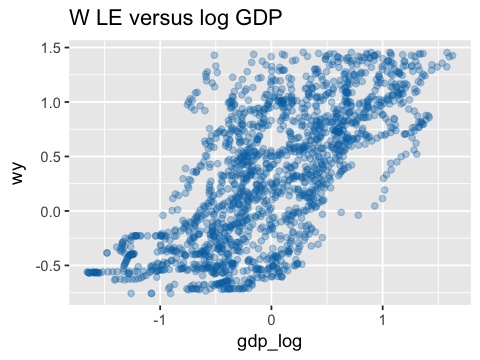

In [217]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(male, aes(y=wy, x=gdp_log)) + geom_point(alpha=0.3, color='#0072B2') +
    labs(title='W LE versus log GDP')

## Male Model

In [221]:
# check sample sizes
male[, ctry_year := interaction(ctry, gyear)]

In [222]:
m1 = brm(formula = wy ~ 1 + gdp_log +  (gdp_log|ctry_year), 
    data = male)

Compiling the C++ model
Start sampling


In [224]:
summary(m1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + gdp_log + (gdp_log | ctry_year) 
   Data: male (Number of observations: 1772) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry_year (Number of levels: 73) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.56      0.05     0.47     0.67        774 1.00
sd(gdp_log)                0.69      0.07     0.57     0.85       1050 1.00
cor(Intercept,gdp_log)    -0.00      0.13    -0.26     0.26        812 1.01

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.39      0.07     0.25     0.51        437 1.01
gdp_log       0.74      0.09     0.56     0.91        821 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.10      0.00 

In [248]:
samples_male = posterior_samples(m1)

### Examine GOF

In [362]:
pred = cbind(male[, .(ctry, year, le, gdp_log, le_log)], predict(m1))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))

In [363]:
pred = merge(pred, max_le, by = 'ctry')

In [231]:
# head(pred, 10)

In [364]:
pred[,  `:=` (
    m = get_orig_values_weibull(m, max_value_le), 
    lo = get_orig_values_weibull(lo, max_value_le),
    hi = get_orig_values_weibull(hi, max_value_le)
    )]

In [370]:
pred_male = pred

In [233]:
max_ex = max(male$le)+25.0
min_ex = min(male$le)-25.0
max_year = max(male$year)
min_year = min(male$year)

plots = list()
for (c in country_labels) {

assign(paste0('plot', which(country_labels == c)), ggplot(pred[ctry==c], aes(x=year, y=le)) + 
    geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
    geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
    geom_point(size=0.3, color='#e34a33', alpha=0.4) +
    labs(title=c) + 
        ylim(min_ex, max_ex) + 
        xlim(min_year, max_year) + theme_minimal() + 
    geom_vline(xintercept = 1950, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1970, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1990, size=0.5, color='red', alpha=0.8, linetype = 'dotted')
       )
    
    }

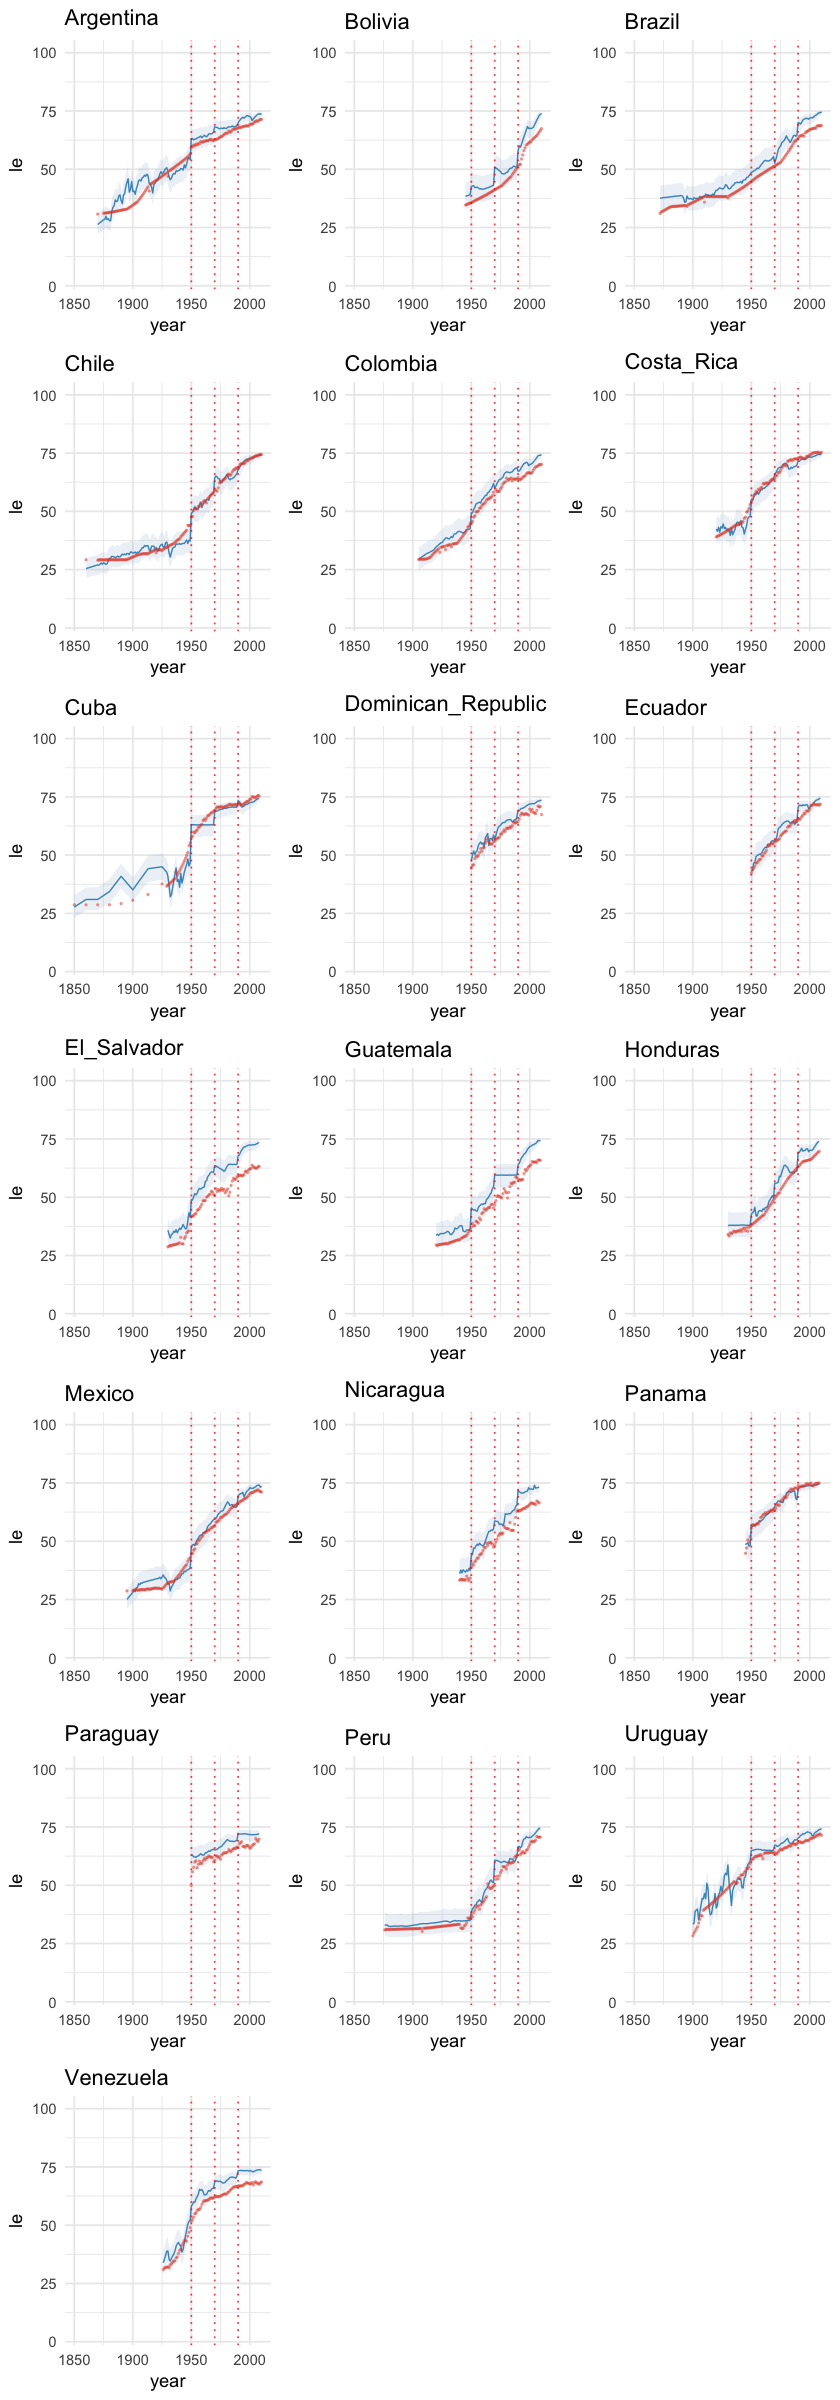

In [234]:
options(repr.plot.width = 7, repr.plot.height = 20)
eval(parse(text=paste0(paste0('plot', 1:length(country_labels), collapse='+'), '+ plot_layout(ncol = 3)')))

# Female

In [403]:
female = df[tseries2==1 & sex==2 & age==0]

female = female[complete.cases(female[, .(Ex, gdp_pc)])]

female = female[, .(ctry, year, gdp_pc, Ex)]
setnames(female, c('gdp_pc', 'Ex'), c('gdp', 'le'))

In [404]:
female[, le_log := scale(log(le), scale=FALSE)]
female[, gdp_log := scale(log(gdp), scale=FALSE)]
female[, year_log := scale(log(year), scale=FALSE)]

In [405]:
# year recode based on the criteria proposed by Alberto
female[year<1950, gyear:=1]
female[year>=1950 & year<1970, gyear:=2]
female[year>=1970 & year<1990, gyear:=3]
female[year>=1990, gyear :=4]
female[, gyear := factor(gyear, levels=1:4, labels=c('1950', '1950-1969', '1970-1989', '1990'))]

In [406]:
# transform variable: weibull
female[, y := le/max(le+1.05), by = ctry] # adjustment is by country!
female[, wy := log(-log(1-y))]

In [419]:
max_le_female = female[, .(max_le = max(le+1.05)), by = ctry]

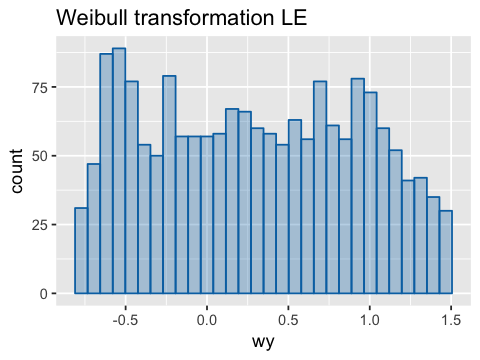

In [255]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(female, aes(wy)) +
    geom_histogram(bins=30, color='#0072B2', fill='#0072B2', alpha=0.3) +
    labs(title='Weibull transformation LE')

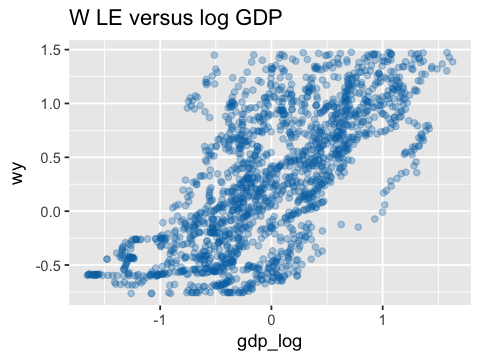

In [257]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(female, aes(y=wy, x=gdp_log)) + geom_point(alpha=0.3, color='#0072B2') +
    labs(title='W LE versus log GDP')

## Female Model

In [560]:
# check sample sizes
female[, ctry_year := interaction(ctry, gyear)]

In [259]:
f1 = brm(formula = wy ~ 1 + gdp_log +  (gdp_log|ctry_year), 
    data = female)

Compiling the C++ model
Start sampling


In [266]:
summary(f1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + gdp_log + (gdp_log | ctry_year) 
   Data: female (Number of observations: 1772) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry_year (Number of levels: 73) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.53      0.05     0.44     0.64        566 1.00
sd(gdp_log)                0.68      0.07     0.57     0.83       1246 1.00
cor(Intercept,gdp_log)     0.07      0.13    -0.19     0.34        649 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.34      0.06     0.22     0.46        491 1.01
gdp_log       0.76      0.09     0.59     0.93        599 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.10      0.0

In [268]:
samples_female = posterior_samples(f1)

### Examine GOF

In [425]:
pred = cbind(female[, .(ctry, year, le, gdp_log, le_log)], predict(f1))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))

In [426]:
pred = merge(pred, max_le_female, by = 'ctry')

In [427]:
pred[,  `:=` (
    m = get_orig_values_weibull(m, max_value_le), 
    lo = get_orig_values_weibull(lo, max_value_le),
    hi = get_orig_values_weibull(hi, max_value_le)
    )]

In [430]:
pred_female = pred

In [431]:
max_ex = max(female$le)+25.0
min_ex = min(female$le)-25.0
max_year = max(female$year)
min_year = min(female$year)

plots = list()
for (c in country_labels) {

assign(paste0('plot', which(country_labels == c)), ggplot(pred[ctry==c], aes(x=year, y=le)) + 
    geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
    geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
    geom_point(size=0.3, color='#e34a33', alpha=0.4) +
    labs(title=c) + 
        ylim(min_ex, max_ex) + 
        xlim(min_year, max_year) + theme_minimal() + 
    geom_vline(xintercept = 1950, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1970, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1990, size=0.5, color='red', alpha=0.8, linetype = 'dotted')
       )
    
    }

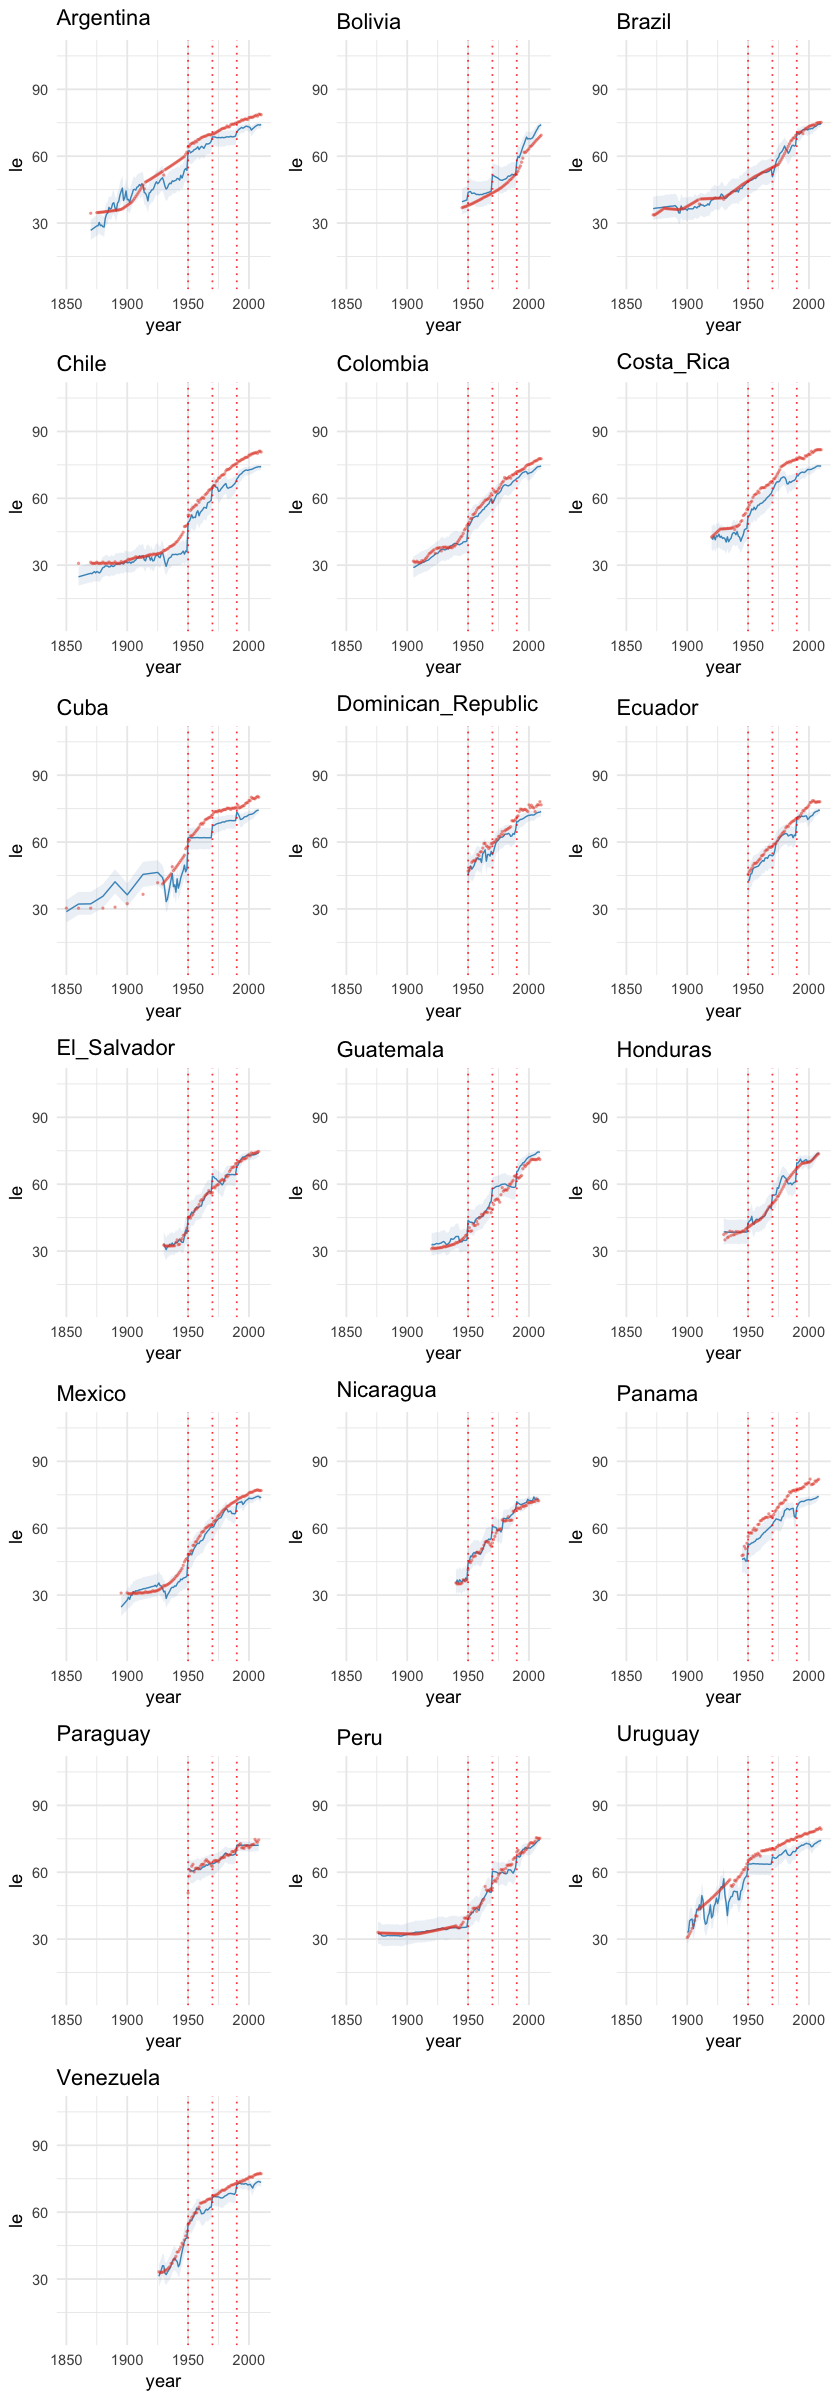

In [432]:
options(repr.plot.width = 7, repr.plot.height = 20)
eval(parse(text=paste0(paste0('plot', 1:length(country_labels), collapse='+'), '+ plot_layout(ncol = 3)')))

# Average Male - Female

In [433]:
total = df[tseries2==1 & age==0, # average life expectancies
           .(Ex=mean(Ex), 
             gdp_pc=max(gdp_pc)
            ), 
           by=.(ctry, year)]

In [434]:
total = total[complete.cases(total[, .(Ex, gdp_pc)])]

total= total[, .(ctry, year, gdp_pc, Ex)]
setnames(total, c('gdp_pc', 'Ex'), c('gdp', 'le'))

In [435]:
total[, le_log := scale(log(le), scale=FALSE)]
total[, gdp_log := scale(log(gdp), scale=FALSE)]
total[, year_log := scale(log(year), scale=FALSE)]

In [436]:
# year recode based on the criteria proposed by Alberto
total[year<1950, gyear:=1]
total[year>=1950 & year<1970, gyear:=2]
total[year>=1970 & year<1990, gyear:=3]
total[year>=1990, gyear :=4]
total[, gyear := factor(gyear, levels=1:4, labels=c('1950', '1950-1969', '1970-1989', '1990'))]

In [437]:
# transform variable: weibull
total[, y := le/max(le+1.05), by = ctry] # adjustment is by country!
total[, wy := log(-log(1-y))]

In [438]:
max_le_total = total[, .(max_le = max(le+1.05)), by = ctry]

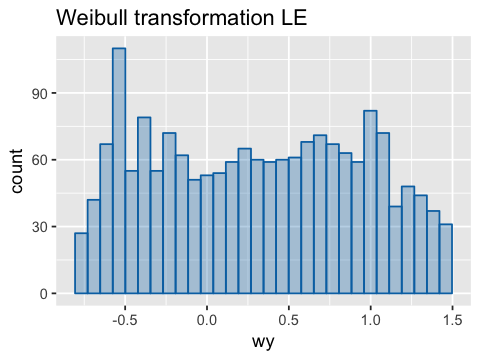

In [299]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(total, aes(wy)) +
    geom_histogram(bins=30, color='#0072B2', fill='#0072B2', alpha=0.3) +
    labs(title='Weibull transformation LE')

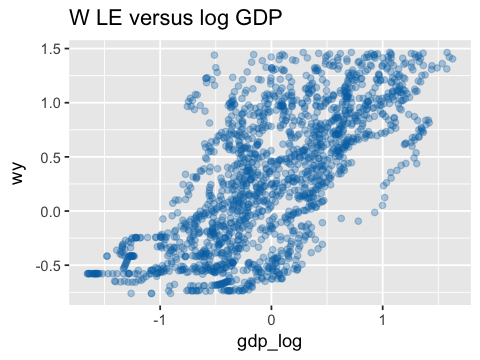

In [300]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(total, aes(y=wy, x=gdp_log)) + geom_point(alpha=0.3, color='#0072B2') +
    labs(title='W LE versus log GDP')

## Total Model

In [526]:
# check sample sizes
total[, ctry_year := interaction(ctry, gyear)]

In [302]:
t1 = brm(formula = wy ~ 1 + gdp_log +  (gdp_log|ctry_year), 
    data = total)

Compiling the C++ model
Start sampling


In [303]:
summary(t1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + gdp_log + (gdp_log | ctry_year) 
   Data: total (Number of observations: 1772) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry_year (Number of levels: 73) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.54      0.05     0.45     0.65        785 1.01
sd(gdp_log)                0.68      0.07     0.57     0.83       1211 1.00
cor(Intercept,gdp_log)     0.04      0.13    -0.21     0.30        757 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.36      0.07     0.24     0.49        424 1.01
gdp_log       0.75      0.09     0.58     0.92        848 1.01

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.10      0.00

In [304]:
samples_total = posterior_samples(t1)

### Examine GOF

In [439]:
pred = cbind(total[, .(ctry, year, le, gdp_log, le_log)], predict(t1))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))

In [440]:
pred = merge(pred, max_le, by = 'ctry')

In [441]:
pred[,  `:=` (
    m = get_orig_values_weibull(m, max_value_le), 
    lo = get_orig_values_weibull(lo, max_value_le),
    hi = get_orig_values_weibull(hi, max_value_le)
    )]

In [308]:
max_ex = max(total$le)+25.0
min_ex = min(total$le)-25.0
max_year = max(total$year)
min_year = min(total$year)

plots = list()
for (c in country_labels) {

assign(paste0('plot', which(country_labels == c)), ggplot(pred[ctry==c], aes(x=year, y=le)) + 
    geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
    geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
    geom_point(size=0.3, color='#e34a33', alpha=0.4) +
    labs(title=c) + 
        ylim(min_ex, max_ex) + 
        xlim(min_year, max_year) + theme_minimal() + 
    geom_vline(xintercept = 1950, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1970, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1990, size=0.5, color='red', alpha=0.8, linetype = 'dotted')
       )
    
    }

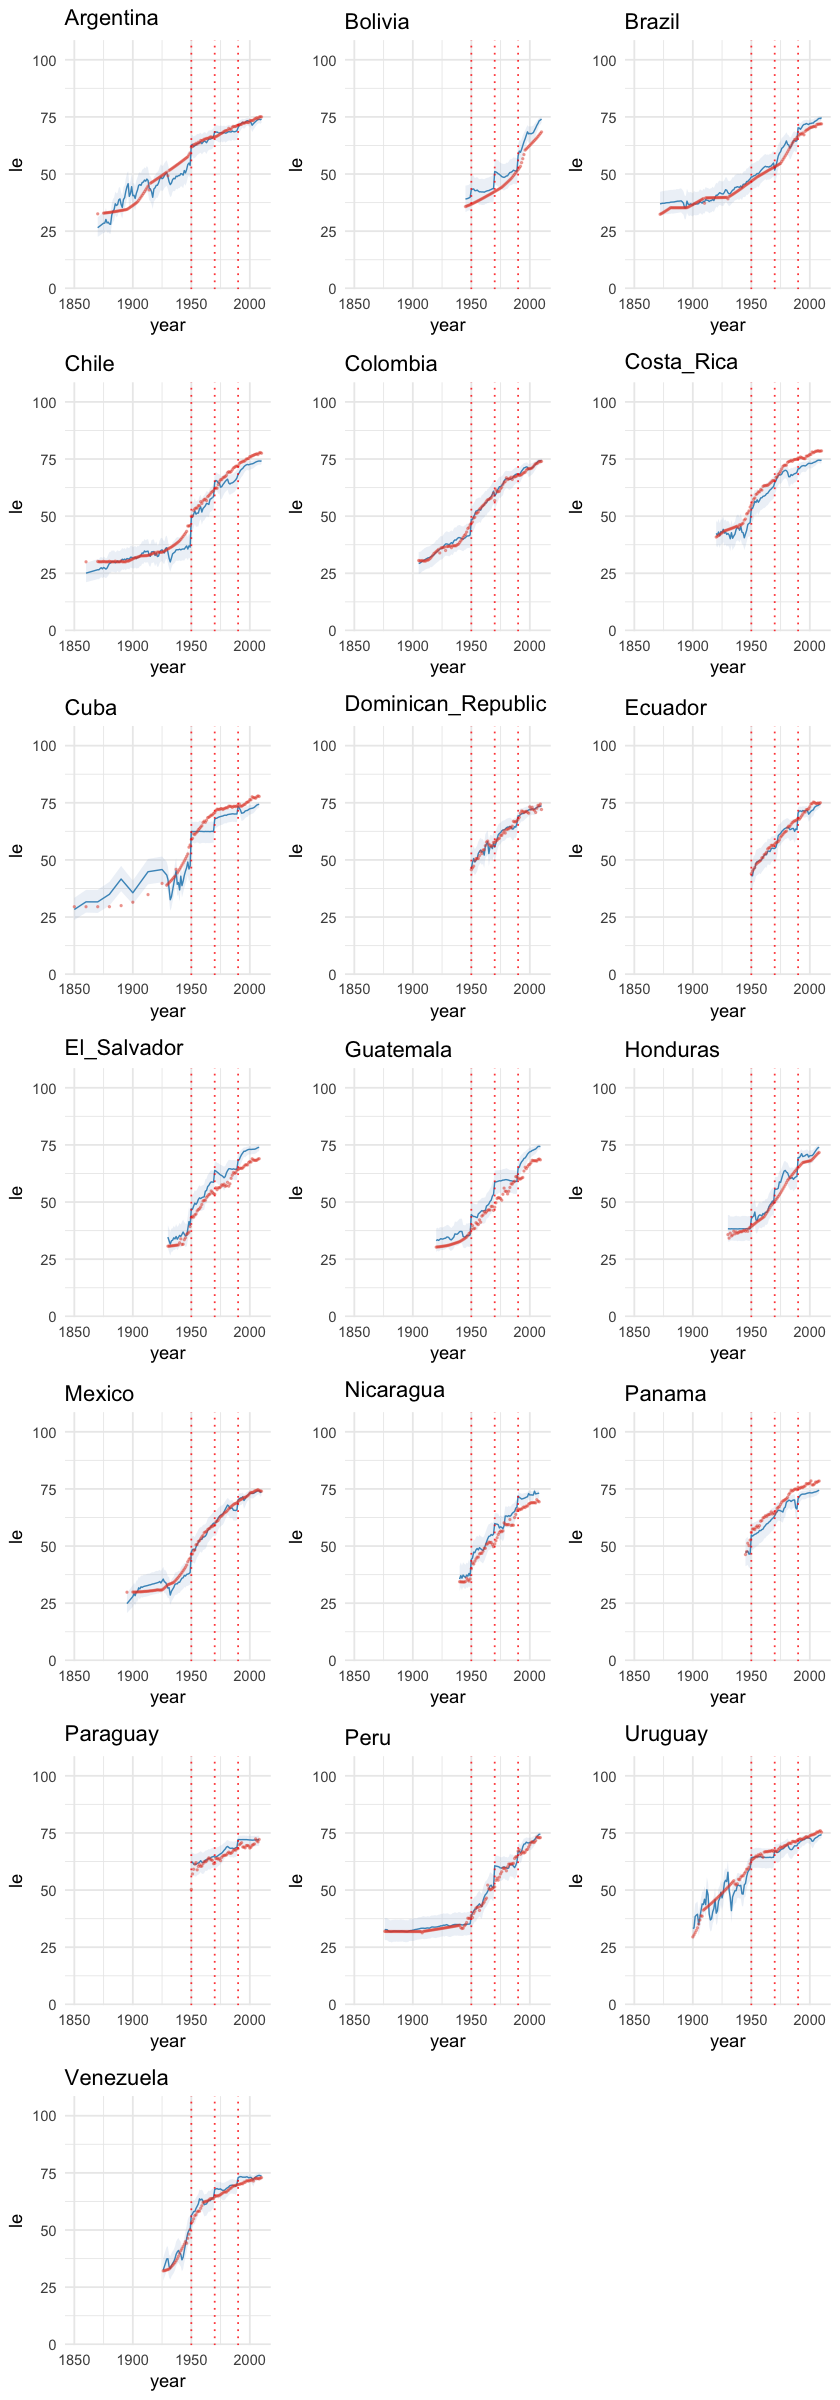

In [309]:
options(repr.plot.width = 7, repr.plot.height = 20)
eval(parse(text=paste0(paste0('plot', 1:length(country_labels), collapse='+'), '+ plot_layout(ncol = 3)')))

# Compute shifts

In [544]:
estimate_shift = function(samples, 
                          country=NULL, 
                          model_year=NULL,
                          le_value=NULL, # value or vector
                          gdp_value = NULL, 
                          max_le_value = NULL,
                          coefficients = c('Intercept', 'gdp_log')) {
    
    colnames = names(samples)
    betas = paste0('b_', coefficients)
    
    random = str_subset(colnames, paste0('^r_.+\\[', country, '.', model_year, ','))

    s = samples[, c(betas, random)]

    pp = (s[,1] + s[,3]) + (s[,2] + s[,4]) * gdp_value
    pg = unlist(sapply(pp, function(x) 
            get_orig_values_weibull(x, max_value=max_le_value)))
    
     return(le_value-pg)
}

In [550]:
compute_shifts = function(samples, model, data, 
                          country_labels,
                          predicted_le=FALSE,
                          iyears,
                          model_year, max_le) {

    shifts = list()

    for (c in country_labels) {
        
        max_le_value = max_le[ctry==c, max_le]
        years = as.numeric(data[ctry == c & year %in% iyears, year])
        model_years = as.character(unique(data[ctry == c, gyear]))

        for (ys in years) {

            gdp_value = data[ctry==c & year==ys, gdp_log]
            
            if (predicted_le) {
                
                le_value = predict(model, data[ctry==c & year==ys], summary=FALSE)
                le_value = unlist(sapply(le_value, function(x) 
                                get_orig_values_weibull(x,max_le_value)))    
            } else {
                le_value =  data[ctry==c & year==ys, le]
                }
            
            for (ysm in model_years) { 
    
                est = estimate_shift(samples, 
                                     country = c, 
                                     model_year = ysm, 
                                     gdp_value = gdp_value,
                                     le_value = le_value,
                                     max_le_value=max_le_value)
                name = paste0(c(c,ys,ysm), collapse='.')
                shifts[[paste0(c(c,ys,ysm), collapse='.')]] = data.table(name, pred_shift = est)

                  }

            }

        }

       shifts = rbindlist(shifts)
       shifts[, c('ctry', 'year', 'segment') := tstrsplit(name, ".", fixed=TRUE)]

       levels = c('1990', '1970-1989', '1950-1969', '1950')
       labels = c('>=1990', '1970-1989', '1950-1969', '<1950')
       shifts[, segment := factor(segment, levels=levels, 
                             labels=labels ) ] 

        return(shifts)
}

In [562]:
iyears = c(1950, 1970, 1990, 2010)
model_year = c('1950', '1950-1969', '1970-1989', '1990')

shift_total_obs = compute_shifts(samples=samples_total, 
                             data=total, 
                             model=t1,
                             country_labels=country_labels, 
                             iyears=iyears, 
                             model_year=model_year,
                             max_le=max_le_total, 
                             predicted_le=FALSE)

shift_total_pred = compute_shifts(samples=samples_total, 
                             data=total, 
                             model=t1,
                             country_labels=country_labels, 
                             iyears=iyears, 
                             model_year=model_year,
                             max_le=max_le_total, 
                             predicted_le=TRUE)

shift_total_obs[, sex := 'total']
shift_total_pred[, sex := 'total']

In [563]:
shift_male_obs = compute_shifts(samples=samples_male, 
                             data=male, 
                             model=m1,
                             country_labels=country_labels, 
                             iyears=iyears, 
                             model_year=model_year,
                             max_le=max_le_male, 
                             predicted_le=FALSE)

shift_male_pred = compute_shifts(samples=samples_male, 
                             data=male, 
                             model=m1,
                             country_labels=country_labels, 
                             iyears=iyears, 
                             model_year=model_year,
                             max_le=max_le_male, 
                             predicted_le=TRUE)

shift_male_obs[, sex := 'male']
shift_male_pred[, sex := 'male']

In [564]:
shift_female_obs = compute_shifts(samples=samples_female, 
                             data=female, 
                             model=f1,
                             country_labels=country_labels, 
                             iyears=iyears, 
                             model_year=model_year,
                             max_le=max_le_female, 
                             predicted_le=FALSE)

shift_female_pred = compute_shifts(samples=samples_female, 
                             data=female, 
                             model=f1,
                             country_labels=country_labels, 
                             iyears=iyears, 
                             model_year=model_year,
                             max_le=max_le_female, 
                             predicted_le=TRUE)

shift_female_obs[, sex := 'female']
shift_female_pred[, sex := 'female']

In [567]:
shift_obs = rbind(shift_total_obs, shift_male_obs, shift_female_obs)
shift_pred = rbind(shift_total_pred, shift_male_pred, shift_female_pred)

In [568]:
head(shift_obs, 5)

In [569]:
dim(shift_obs)

[1] 3096000       6

In [570]:
dim(shift_pred)

[1] 3096000       6

In [572]:
# shift_obs[, .N, by=.(ctry, year, segment, sex)]
# shift_pred[, .N, by=.(ctry, year, segment, sex)]

In [575]:
sample_shift_pred = shift_pred[,.SD[sample(.N, min(1000,.N))], by=.(ctry, year, segment, sex)]
sample_shift_obs = shift_obs[,.SD[sample(.N, min(1000,.N))], by=.(ctry, year, segment, sex)]

In [577]:
fwrite(sample_shift_pred[,.(ctry, year, segment, sex, pred_shift)], 'shifts_pred.csv')
fwrite(sample_shift_obs[,.(ctry, year, segment, sex, pred_shift)], 'shifts_obs.csv')

### Examples

Picking joint bandwidth of 0.191


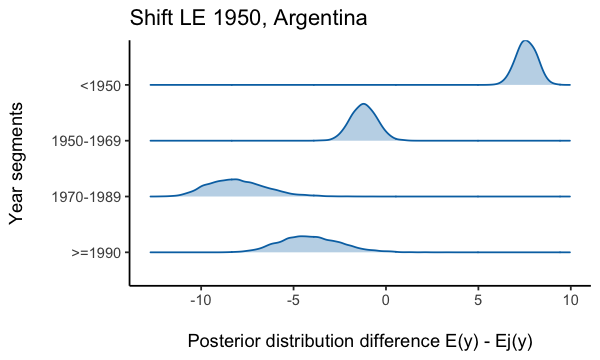

In [341]:
country = 'Argentina'
syear = '1950'

options(repr.plot.width = 5, repr.plot.height = 3)
p = ggplot(shift_male[year==syear & ctry==country, ], aes(y=segment)) +
      geom_density_ridges(aes(x=pred_shift),
               alpha=0.3, color='#0072B2', fill='#0072B2', scale=0.8) +
      labs(x='\nPosterior distribution difference E(y) - Ej(y)', 
          y='Year segments\n', title=paste0('Shift LE ', syear, ', ', country)) + 
      theme_classic()
print(p)

Picking joint bandwidth of 0.112


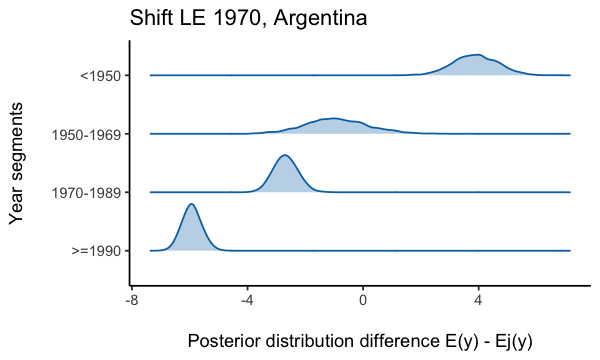

In [331]:
country = 'Argentina'
syear = '1970'

options(repr.plot.width = 5, repr.plot.height = 3)
p = ggplot(shift_total[year==syear & ctry==country, ], aes(y=segment)) +
      geom_density_ridges(aes(x=pred_shift),
               alpha=0.3, color='#0072B2', fill='#0072B2', scale=0.8) +
      labs(x='\nPosterior distribution difference E(y) - Ej(y)', 
          y='Year segments\n', title=paste0('Shift LE ', syear, ', ', country)) + 
      theme_classic()
print(p)

Picking joint bandwidth of 0.123


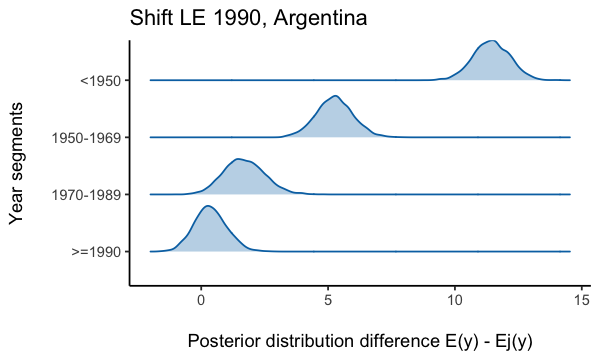

In [415]:
country = 'Argentina'
syear = '1990'

options(repr.plot.width = 5, repr.plot.height = 3)
p = ggplot(shift_total[year==syear & ctry==country, ], aes(y=segment)) +
      geom_density_ridges(aes(x=pred_shift),
               alpha=0.3, color='#0072B2', fill='#0072B2', scale=0.8) +
      labs(x='\nPosterior distribution difference E(y) - Ej(y)', 
          y='Year segments\n', title=paste0('Shift LE ', syear, ', ', country)) + 
      theme_classic()
print(p)

In [447]:
# combine predictions 

pred_male[, sex := 'male']
pred_female[, sex := 'female']
pred_total[, sex := 'total']

pred = rbind(pred_male, pred_female, pred_total)
fwrite(pred[, .(ctry, year, sex, le, m, lo, hi)], 'pred.csv')

# Lags

In [518]:
estimate_lags = function(samples, country=NULL, 
                          model_year=NULL,
                          year=NULL,
                          gdp_value = NULL, 
                          max_le_value = NULL,
                          le_data = NULL,
                          coefficients = c('Intercept', 'gdp_log')) {
    
    le_values = le_data[ctry==country, .(year, le)]
    
    colnames = names(samples)
    betas = paste0('b_', coefficients)
    
    random = str_subset(colnames, paste0('^r_.+\\[', country, '.', model_year, ','))

    s = samples[, c(betas, random)]
    print(head(s, 2))
    pp = (s[,1] + s[,3]) + (s[,2] + s[,4]) * gdp_value
    pg = unlist(sapply(pp, function(x) 
            get_orig_values_weibull(x, max_value=max_le_value)))
     
    ind = NULL
    for (i in 1:length(pg)) {
        ind[i] = which.min(abs(le_values$le - pg[i]))
        }
    
    return(le_values[ind, year]-year)
}

In [516]:
compute_lags = function(samples, 
                          data, 
                          country_labels, 
                          iyears,
                          max_le) {

    model_years = list('1950' = '1950', '1970' = '1950-1969', '1990' = '1970-1989')

    
    lags = list()

    for (c in country_labels) {

        max_le_value = max_le[ctry==c, max_le]
        iyears = as.numeric(data[ctry == c & year %in% iyears, year])
        model_years =

        for (ys in iyears) {
            
            print(c)
            print(ys)
            est = estimate_lags(samples, country=c, 
                      model_year=model_years[[as.character(ys)]], 
                      year=ys,
                      le_data = data,
                      gdp_value=data[ctry==c & year==ys, gdp_log],
                      max_le_value=max_le_value
                     )

                name = paste0(c(c,ys), collapse='.')
                lags[[paste0(c(c,ys), collapse='.')]] = data.table(name, pred_lag = est)

                  }

            }


       lags = rbindlist(lags)
       lags[, c('ctry', 'year') := tstrsplit(name, ".", fixed=TRUE)]

#        levels = c('1990', '1970-1989', '1950-1969', '1950')
#        labels = c('>=1990', '1970-1989', '1950-1969', '<1950')
#        shifts[, segment := factor(segment, levels=levels, 
#                              labels=labels ) ] 

        return(lags)
}

In [520]:
# lags_total = compute_lags(samples=samples_total, 
#                           data=total, 
#                           country_labels=country_labels,
#                           iyears=c(1950, 1970, 1990),
#                           max_le=max_le_total)